In [28]:
import tensorflow as tf
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy.interpolate as interp
import keras 
from keras import layers

In [3]:
def inner_outer_limits(X,Y,wr,wl):
    #function to separate the inner and outer limits of the track from the centerline and track widths.
    #Inputs all 4 arrays from 1 circuit
    xouter = np.array([])
    youter = np.array([])
    xinner = np.array([])
    yinner = np.array([])
    for i in range(len(X)-1):
        v = np.array([X[i+1]-X[i],Y[i+1]-Y[i]])
        #outer calculation - as explained in the methodology
        n = [v[1],-v[0]]
        unit = n/((n[1]**2+n[0]**2)**0.5)
        t = unit*wr[i]
        x0 = X[i]+t[0]
        y0 = Y[i]+t[1]
        xouter = np.append(xouter,x0)
        youter = np.append(youter,y0)
        #inner calculation - oposite from the inner
        n = [-v[1],v[0]]
        unit = n/((n[0]**2+n[1]**2)**0.5)
        t = unit*wl[i]
        x0 = X[i]+t[0]
        y0 = Y[i]+t[1]
        xinner = np.append(xinner,x0)
        yinner = np.append(yinner,y0)
        #returns all 4 arrays 
    return (xouter,youter,xinner,yinner)

def resize_track(X,Y,wr,wl):
    #function to resize the data points of a circuit from whatever number to 1000 points.
    #inputs the track raw data points (centerline and widths)
    trackinterpx = interp.interp1d(np.arange(X.size),X)
    trackstretchx = trackinterpx(np.linspace(0,X.size-1,1001))
    trackinterpy = interp.interp1d(np.arange(Y.size),Y)
    trackstretchy = trackinterpy(np.linspace(0,Y.size-1,1001))
    
    wrinterp = interp.interp1d(np.arange(wr.size),wr)
    wrstretch = wrinterp(np.linspace(0,wr.size-1,1001))
    wlinterp = interp.interp1d(np.arange(wl.size),wl)
    wlstretch = wlinterp(np.linspace(0,wl.size-1,1001))
    return (trackstretchx,trackstretchy,wrstretch,wlstretch)

def resize_raceline(racelinex,raceliney):
    #same function was resize_track but with the raceline coordinates X and Y
    raceinterpx = interp.interp1d(np.arange(racelinex.size),racelinex)
    racestretchx = raceinterpx(np.linspace(0,racelinex.size-1,1000))
    raceinterpy = interp.interp1d(np.arange(raceliney.size),raceliney)
    racestretchy = raceinterpy(np.linspace(0,raceliney.size-1,1000))
    return(racestretchx,racestretchy)

def circuitprep(trackpath,racepath,plot=False):
    #function that groups all 3 functions defined above and converts the raw data into a 6 array circuit definition prepared for the ANN.
    #has a plot selector that can plot the final result to check if the functions are working.
    track = pd.read_csv(trackpath)
    raceline = pd.read_csv(racepath)
    [Xstr,Ystr,wrstr,wlstr] = resize_track(track["# x_m"],track["y_m"],track["w_tr_right_m"],track["w_tr_right_m"])
    [racestretchx,racestretchy] = resize_raceline(raceline["# x_m"], raceline["y_m"])
    [xouter,youter,xinner,yinner] = inner_outer_limits(Xstr,Ystr,wrstr,wlstr)
    batch = np.array([xouter,youter,xinner,yinner,racestretchx,racestretchy])
    if plot==True:
        for i in [0,2,4]:
            plt.plot(batch[i],batch[i+1])
    return batch

In [4]:
#define the raw data repositories
tracks = [r'tracks\Austin.csv',
          r'tracks\BrandsHatch.csv',
          r'tracks\Budapest.csv',
          r'tracks\Catalunya.csv',
          r'tracks\Hockenheim.csv',
          r'tracks\IMS.csv',
          r'tracks\Melbourne.csv',
          r'tracks\MexicoCity.csv',
          r'tracks\Montreal.csv',
          r'tracks\Monza.csv',
          r'tracks\MoscowRaceway.csv',
          r'tracks\Norisring.csv',
          r'tracks\Nuerburgring.csv',
          r'tracks\Oschersleben.csv',
          r'tracks\Sakhir.csv',
          r'tracks\SaoPaulo.csv',
          r'tracks\Sepang.csv',
          r'tracks\Shanghai.csv',
          r'tracks\Silverstone.csv',
          r'tracks\Sochi.csv',
          r'tracks\Spa.csv',
          r'tracks\Spielberg.csv',
          r'tracks\Suzuka.csv',
          r'tracks\YasMarina.csv',
          r'tracks\Zandvoort.csv']
racelines = [r'racelines\Austin.csv',
          r'racelines\BrandsHatch.csv',
          r'racelines\Budapest.csv',
          r'racelines\Catalunya.csv',
          r'racelines\Hockenheim.csv',
          r'racelines\IMS.csv',
          r'racelines\Melbourne.csv',
          r'racelines\MexicoCity.csv',
          r'racelines\Montreal.csv',
          r'racelines\Monza.csv',
          r'racelines\MoscowRaceway.csv',
          r'racelines\Norisring.csv',
          r'racelines\Nuerburgring.csv',
          r'racelines\Oschersleben.csv',
          r'racelines\Sakhir.csv',
          r'racelines\SaoPaulo.csv',
          r'racelines\Sepang.csv',
          r'racelines\Shanghai.csv',
          r'racelines\Silverstone.csv',
          r'racelines\Sochi.csv',
          r'racelines\Spa.csv',
          r'racelines\Spielberg.csv',
          r'racelines\Suzuka.csv',
          r'racelines\YasMarina.csv',
          r'racelines\Zandvoort.csv']

In [4]:
#check that the functions are working
circuit = np.array([circuitprep(tracks[14],racelines[14],plot=True)])
np.shape(circuit)

(1, 6, 1000)

In [5]:
#define the dataset space with 0 and append the first 15 raw tracks
dataset = np.zeros([12000,6,1000])
for i in range(len(tracks)):
    circuit = np.array([circuitprep(tracks[i],racelines[i])])
    dataset[i] = circuit
np.shape(dataset)

(12000, 6, 1000)

In [6]:
for i in range(len(tracks)):
    circuit = np.array([circuitprep(tracks[i],racelines[i])])
    circuit[0,1] = -circuit[0,1]
    circuit[0,3] = -circuit[0,3]
    circuit[0,5] = -circuit[0,5]
    dataset[25+i] =  circuit
for i in range(len(tracks)):
    circuit = np.array([circuitprep(tracks[i],racelines[i])])
    circuit[0,0] = -circuit[0,0]
    circuit[0,2] = -circuit[0,2]
    circuit[0,4] = -circuit[0,4]
    dataset[50+i] =  circuit
for i in range(len(tracks)):
    circuit = np.array([circuitprep(tracks[i],racelines[i])])
    circuit[0,1] = -circuit[0,1]
    circuit[0,3] = -circuit[0,3]
    circuit[0,5] = -circuit[0,5]
    circuit[0,0] = -circuit[0,0]
    circuit[0,2] = -circuit[0,2]
    circuit[0,4] = -circuit[0,4]
    dataset[75+i] =  circuit
np.shape(dataset)
#all 3 axis mirroring for the 25 tracks = 100 tracks in total

(12000, 6, 1000)

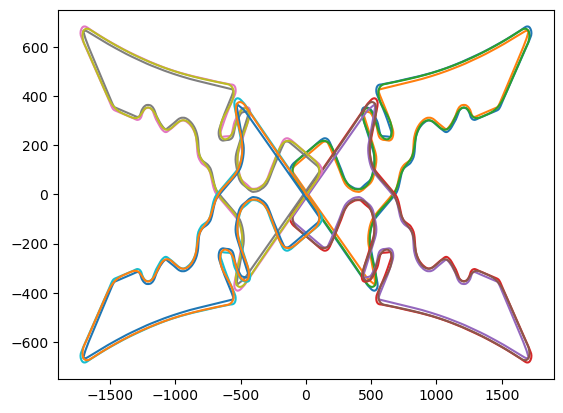

In [7]:
n = 0
for i in [0,2,4]:
        plt.plot(dataset[n,i],dataset[n,i+1])
n = 25
for i in [0,2,4]:
        plt.plot(dataset[n,i],dataset[n,i+1])
n = 50
for i in [0,2,4]:
        plt.plot(dataset[n,i],dataset[n,i+1])
n = 75
for i in [0,2,4]:
        plt.plot(dataset[n,i],dataset[n,i+1])
#chekc the mirroring

In [7]:
def rotation(circuit,alpha):
    #rotation function that rotates the track datapoints using an angle "alpha".
    rotated = np.zeros([6,1000])
    for i in [0,2,4]:
        rotated[i] = circuit[i]*np.cos(np.radians(alpha)) - circuit[i+1]*np.sin(np.radians(alpha))
        rotated[i+1] = circuit[i]*np.sin(np.radians(alpha)) + circuit[i+1]*np.cos(np.radians(alpha))
    return rotated

(6, 1000)


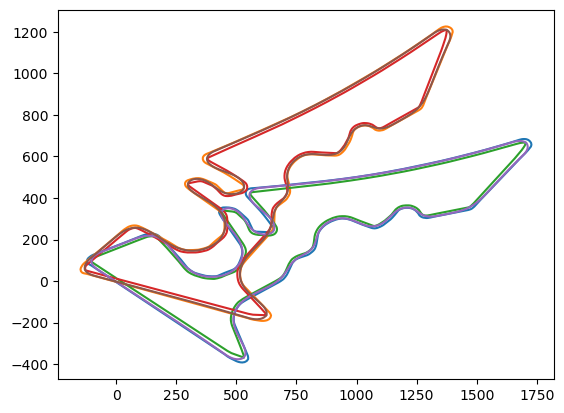

In [9]:
test = rotation(dataset[0],20)
print(np.shape(test))
n = 0
for i in [0,2,4]:
        plt.plot(dataset[n,i],dataset[n,i+1])
        plt.plot(test[i],test[i+1])


In [10]:
for i in range (100):
    for k in range(12):
         dataset[i+k*100] = rotation(dataset[i],k*30)
#rotate the 100 circuits of the dataset in 12 different angles = 1200 circuits in total

In [11]:
for i in range(len(dataset)):
        dataset[i] = dataset[i]-dataset[i].min()
        dataset[i] = dataset[i]/dataset[i].max()
#normalize the dataset from 0 to 1.

C:\Users\erikv.DESKTOP-JJA0C1I\AppData\Local\Temp\ipykernel_6204\2920109994.py:3: RuntimeWarning: invalid value encountered in divide
  dataset[i] = dataset[i]/dataset[i].max()


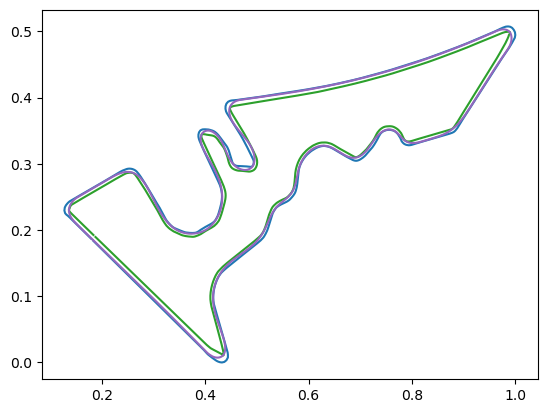

In [13]:
n=0
for i in [0,2,4]:
        plt.plot(dataset[n,i],dataset[n,i+1])
        plt.plot(dataset[n+1200,i],dataset[n+1200,i+1])
#check normalization

In [14]:
w = 1200
for i in range(w):
    for j in range(6):
        dataset[i+w,j,:] = dataset[i,j,:]*0.98
    for j in range(6):
        dataset[i+w*2,j,:] = dataset[i,j,:]*0.95
    for j in range(6):
        dataset[i+w*3,j,:] = dataset[i,j,:]*0.92
    for j in range(6):
        dataset[i+w*4,j,:] = dataset[i,j,:]*0.90
    for j in range(6):
        dataset[i+w*5,j,:] = dataset[i,j,:]*0.88
    for j in range(6):
        dataset[i+w*6,j,:] = dataset[i,j,:]*0.85
    for j in range(6):
        dataset[i+w*7,j,:] = dataset[i,j,:]*0.82
    for j in range(6):
        dataset[i+w*8,j,:] = dataset[i,j,:]*0.80
    for j in range(6):
        dataset[i+w*9,j,:] = dataset[i,j,:]*0.78
# scale the dataset into 9 different scaling factors = 12000 circuits in total.

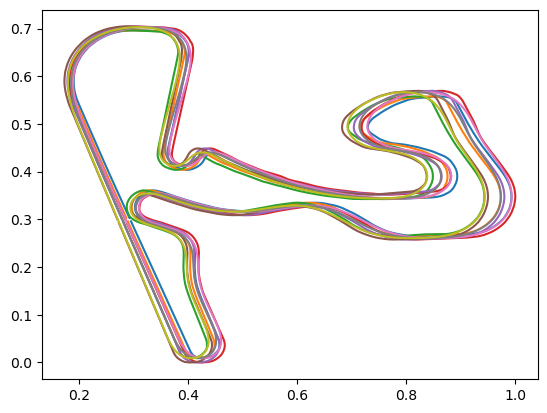

In [15]:
n = 674
for i in [0,2,4]:
        plt.plot(dataset[n,i],dataset[n,i+1])
        plt.plot(dataset[n+w,i],dataset[n,i+1])
        plt.plot(dataset[n+w*2,i],dataset[n,i+1])
# check the scaling

In [16]:
# export the dataset into a hkl file
import hickle as hkl
hkl.dump(dataset,'datasetshort.hkl')

In [23]:
# The test tracks must be as close to the raw data as possible
testtracks = np.zeros([5,6,1000])
for i in range(5):
    circuit = np.array([circuitprep(tracks[i],racelines[i])])
    circuitrot = rotation(circuit[0],15)
    testtracks[i] = circuitrot
#only circuit prep function has been used, with a 15 degree (non used angle in the original dataset) rotation.
# this ensures new unseen data is used for testing

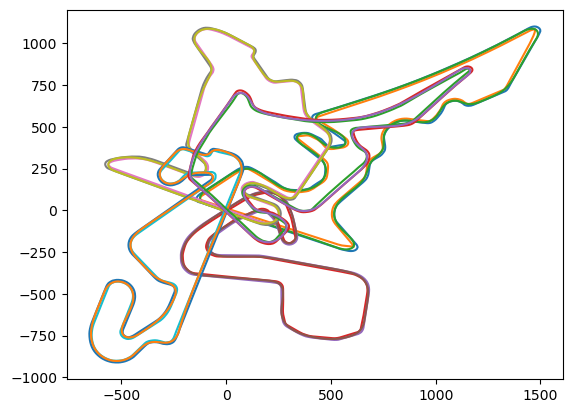

In [26]:
for n in range(5):
    for i in [0,2,4]:
        plt.plot(testtracks[n,i],testtracks[n,i+1])
#check the test dataset

In [29]:
# export into a hkl file
import hickle as hkl
hkl.dump(testtracks,'testtracks.hkl')